### Import Dependencies

In [2]:
from splinter import Browser
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd

In [3]:
# PCA dependencies
from sklearn.preprocessing import StandardScaler

In [4]:
# Setup splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Get LATEST driver version for 91.0.4472
Trying to download new driver from https://chromedriver.storage.googleapis.com/91.0.4472.101/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\Andrew\.wdm\drivers\chromedriver\win32\91.0.4472.101]


In [5]:
#Page URL
url = 'https://www.trulia.com/for_sale/36.63199,38.40726,-78.77798,-76.20855_xy/9_zm/'
browser.visit(url)

### Web Scrape

In [6]:
# Initialize Lists
housePrices = []
houseRegion = []
houseSqrFt = []
houseBath = []
houseBed = []


#For each page of houses
for x in range(1, 50):
    
    print(f'Processing Page {x} - Initialize', end='\r')
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')
    
    #Data scrape from html
    prices = soup.find_all('div', {'data-testid' : "property-price"})
    beds = soup.find_all('div', {'data-testid' : "property-beds"})
    baths = soup.find_all('div', {'data-testid' : "property-baths"})
    sqrFt = soup.find_all('div', {'data-testid' : "property-floorSpace"})
    region = soup.find_all('div', {'data-testid' : "property-region"})
    print(f'Processing Page {x} - Data Scrape', end='\r')
    
    #Add scraped data to lists
    for i, price in enumerate(prices):        
        housePrices.append(price.text)
        houseBed.append(beds[i].text[0])
        houseBath.append(baths[i].text[0])
        houseSqrFt.append(sqrFt[i].text.split()[0])
        houseRegion.append(region[i].text)
    print(f'Processing Page {x} - List append', end='\r')

    #Next Page button
    browser.find_by_xpath('//*[@id="resultsColumn"]/nav/ul/li[8]/a/div/svg')
    print(f'Processing Page {x} - Next Page', end='\r')
    
    

In [7]:
# Initialize Data Frame
house_df = pd.DataFrame(
    {
        'Prices': housePrices,
        'Beds': houseBed,
        'Baths': houseBath,
        'SquareFt': houseSqrFt,
        'Loc': houseRegion
    }

)

In [8]:
#Data Conversion

try: 
    house_df.SquareFt = house_df.SquareFt.str.replace(',', '').astype(int)
except:
    print('Sqrft Data already converted.')
try:
    house_df.Beds = house_df.Beds.astype(int)
except:
    print('Bed Data already converted.')
try:
    house_df.Bath = house_df.Bath.astype(int)
except:
    print('Bath Data already converted.')

try:
    house_df.Prices = house_df.Prices.replace('[\$,]', '', regex=True).astype(float)
except:
    print('Price Data already Converted.')


Bath Data already converted.


In [9]:
house_df.dtypes

Prices      float64
Beds          int32
Baths        object
SquareFt      int32
Loc          object
dtype: object

In [10]:
house_df

,Prices,Beds,Baths,SquareFt,Loc
0,270000.0,4,3,2283,"Western Branch South, Chesapeake, VA"
1,299750.0,4,2,1750,"South Norfolk, Chesapeake, VA"
2,260000.0,3,2,2444,"North Chesterfield, VA"
3,380000.0,5,3,2750,"Midlothian, VA"
4,489000.0,3,3,2351,"Glen Allen, VA"
...,...,...,...,...,...
1465,240000.0,4,2,2620,"Mercury Central, Hampton, VA"
1466,310000.0,4,3,2000,"Great Bridge East, Chesapeake, VA"
1467,350000.0,4,3,2238,"Fredericksburg, VA"
1468,295000.0,4,3,2016,"Henrico, VA"


### Export to CSV to load into database


In [11]:
house_df.to_csv('./Resources/housingdata.csv')

### Additional Analysis

In [12]:
features = ['Prices', 'Beds', 'Baths', 'SquareFt']

In [13]:
x = house_df.loc[:, features].values

y = house_df.loc[:,['Loc']].values

x = StandardScaler().fit_transform(x)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(
    data = principalComponents,
    columns = ['pc1', 'pc2']
    
)

In [15]:
finalDf = pd.concat(
    [principal_df, house_df[['Loc']]], axis = 1
)

In [16]:
finalDf

,pc1,pc2,Loc
0,0.931828,-0.921710,"Western Branch South, Chesapeake, VA"
1,-0.410046,-0.214206,"South Norfolk, Chesapeake, VA"
2,-0.533326,0.125796,"North Chesterfield, VA"
3,2.651467,-0.729037,"Midlothian, VA"
4,1.123012,1.524844,"Glen Allen, VA"
...,...,...,...
1465,0.340908,-0.722039,"Mercury Central, Hampton, VA"
1466,0.769024,-0.590567,"Great Bridge East, Chesapeake, VA"
1467,1.197692,-0.274789,"Fredericksburg, VA"
1468,0.727760,-0.712088,"Henrico, VA"


In [19]:
import matplotlib.pyplot as plt 
import matplotlib

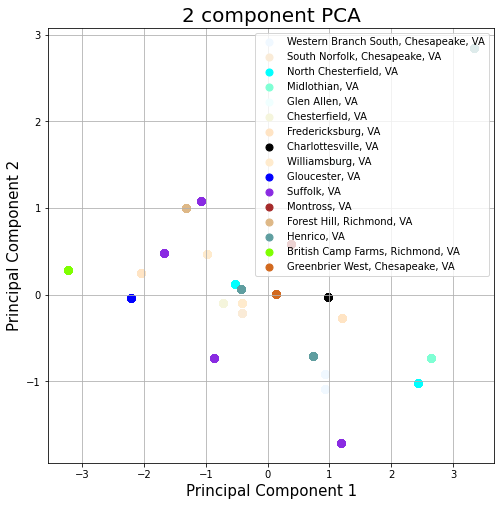

In [20]:

# Additional Plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(pd.unique(house_df.Loc.values))
colors = list(matplotlib.colors.cnames.values())[0:16]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Loc'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()